In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import nltk
import string

from nltk.stem.rslp import RSLPStemmer
from sklearn.model_selection import train_test_split
from nltk.tokenize import RegexpTokenizer
from matplotlib.patches import Patch

nltk.download('stopwords')
nltk.download('rslp')

[nltk_data] Downloading package stopwords to /home/jv/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to /home/jv/nltk_data...
[nltk_data]   Package rslp is already up-to-date!


True

# **Baixando os dataframes de treino e teste:**

In [46]:
dataframe_baixado = True
try:
    #df = pd.read_csv('../discurso_odio.csv')
    df = pd.read_csv('../Tweets.csv')
except FileNotFoundError:
    print("Certifique-se de que o arquivo csv está na raiz do projeto.")
    dataframe_baixado = False

if (dataframe_baixado):
    print("Dataframe carregado com sucesso!")

Dataframe carregado com sucesso!


# **Visualizando os dataframes baixados:**

In [47]:
print ("Shape do dataframe de treino: ", df.shape)
df.head(5)

Shape do dataframe de treino:  (14640, 15)


,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


# **Selecionando colunas:**

In [48]:
reviews = np.array(df['text'])
labels = np.array(df['airline_sentiment'])

# Redefindindo o dataframe
df = pd.DataFrame({
    'review': reviews,
    'label': labels
})

In [49]:
# Mapeamento: 0 para 'negative', 1 para 'neutral' e 'positive'
def map_label(label):
    if label == 'negative':
        return 0
    else:
        return 1

# Aplica o mapeamento
df['label_numeric'] = df['label'].apply(map_label)

# Exibe a nova distribuição de labels numéricas
print(df['label_numeric'].value_counts())

label_numeric
0    9178
1    5462
Name: count, dtype: int64


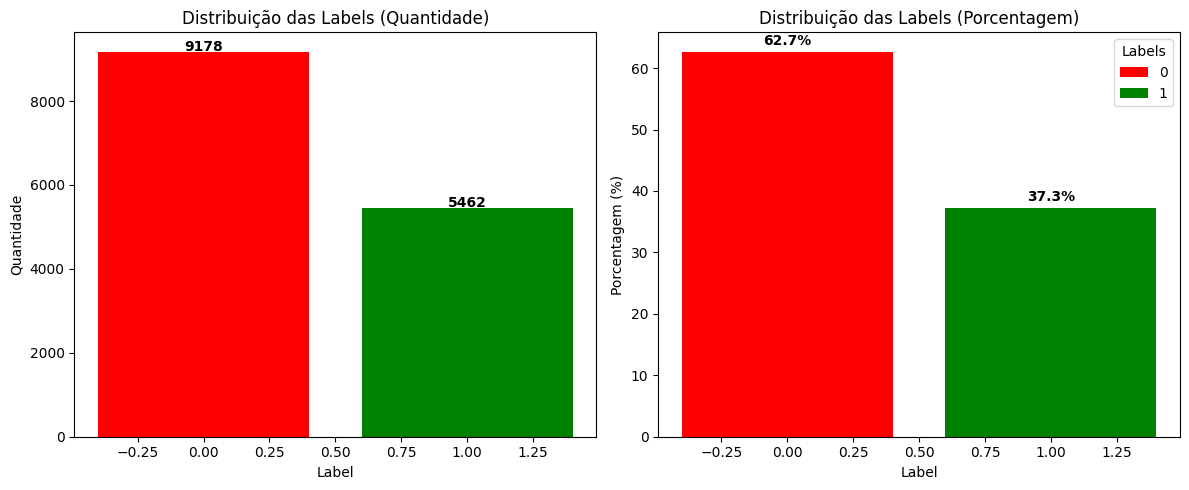

In [50]:
# Contando quantidade de cada label
label_counts = df['label_numeric'].value_counts()
labels = label_counts.index
counts = label_counts.values

# Calculando porcentagens
percentages = counts / counts.sum() * 100

# Definindo cores diferentes para cada label
colors = ['red', 'green']

# Criando figura com dois subplots lado a lado
fig, axes = plt.subplots(1, 2, figsize=(12,5))

# --- Gráfico 1: Quantidade ---
axes[0].bar(labels, counts, color=colors)
axes[0].set_title('Distribuição das Labels (Quantidade)')
axes[0].set_xlabel('Label')
axes[0].set_ylabel('Quantidade')
for i, v in enumerate(counts):
    axes[0].text(i, v + 5, str(v), ha='center', fontweight='bold')

# --- Gráfico 2: Porcentagem ---
axes[1].bar(labels, percentages, color=colors)
axes[1].set_title('Distribuição das Labels (Porcentagem)')
axes[1].set_xlabel('Label')
axes[1].set_ylabel('Porcentagem (%)')
for i, v in enumerate(percentages):
    axes[1].text(i, v + 1, f"{v:.1f}%", ha='center', fontweight='bold')

# --- Adicionando legenda ---
legend_elements = [Patch(facecolor='red', label='0'),
                   Patch(facecolor='green', label='1')]
axes[1].legend(handles=legend_elements, title="Labels")

plt.tight_layout()
plt.show()

# **Realizando pré-processamento do texto:**

In [51]:
# Definindo stopwords com a lib NLTK configurada para PT-BR
stop_words = list(nltk.corpus.stopwords.words('portuguese'))
                  
def pre_process_text(text: str) -> str:
    # Deixando o texto lowercase e removendo a pontuação
    text = text.lower().translate(str.maketrans('', '', string.punctuation))
    
    # Tokenização
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(text)
    
    # Inicializando o stemmer para português
    stemmer = RSLPStemmer()

    # Lematização e filtragem dos tokens:
    # 1- Aplicando a lematização
    # 2- não pode ser stopword
    # 3- ter mais de 1 caractere (para evitar artigos)
    # 4- O 1° caractere do token não pode ser número
    # 5- Não começa com @
    tokens = [ stemmer.stem(word) for word in tokens 
              if word not in stop_words
              and len(word) > 1
              and not word[0].isdigit()
              and not word.startswith('@')]
    
    # Reconstruindo texto
    return ' '.join(tokens)

# Aplicando o pré-processamento do texto no dataframe
df['review_clean'] = df['review'].apply(pre_process_text)

In [52]:
# Embaralhando o dataframe de treino
df = df.sample(frac=1, random_state=42)  

# Separando features e alvo
X = df['review']
y = df['label_numeric']

# 1ª etapa: divide o dataset em 75% treino e 25% (validação + teste)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

print(f"Dimensões do conjunto de treino: {X_train.shape}")
print(f"Dimensões do conjunto de validação: {X_val.shape}")

Dimensões do conjunto de treino: (10980,)
Dimensões do conjunto de validação: (3660,)


In [53]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tokenização
max_words = 10000  # tamanho do vocabulário
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)

# Padding das sequências para um tamanho fixo
max_len = 100  # número máximo de tokens por sequência
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=max_len, padding='post', truncating='post')

print("Pré-processamento, split e tokenização concluídos!")
print("Número de palavras no vocabulário:", min(max_words, len(tokenizer.word_index)))
print("Tamanho das sequências:", X_train_pad.shape[1])

Pré-processamento, split e tokenização concluídos!
Número de palavras no vocabulário: 10000
Tamanho das sequências: 100


# **Treinamento da rede neural:**


In [54]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.metrics import Precision, Recall, F1Score 

# Parâmetros
embedding_dim = 128   # dimensão dos vetores de embedding
max_len = X_train_pad.shape[1]
vocab_size = min(10000, len(tokenizer.word_index) + 1)

# Definindo a RNN
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len))
model.add(LSTM(64, return_sequences=False))  
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compilação
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy', # Mantém a acurácia para referência
        Precision(name='precision'), 
        Recall(name='recall'),
        F1Score(name='f1_score') # F1-score não é uma métrica padrão em Keras.
    ]
)

# Treinamento
history = model.fit(
    X_train_pad,
    y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_val_pad, y_val),
)

Epoch 1/20


/home/jv/Documentos/GitHub/Projetos-Topicos-Avancados-em-IA/venv/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


344/344 ━━━━━━━━━━━━━━━━━━━━ 32s 79ms/step - accuracy: 0.6261 - f1_score: 0.5435 - loss: 0.6635 - precision: 0.2143 - recall: 7.3224e-04 - val_accuracy: 0.6270 - val_f1_score: 0.5433 - val_loss: 0.6636 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/20
344/344 ━━━━━━━━━━━━━━━━━━━━ 27s 79ms/step - accuracy: 0.6269 - f1_score: 0.5435 - loss: 0.6628 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.6270 - val_f1_score: 0.5433 - val_loss: 0.6607 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/20
344/344 ━━━━━━━━━━━━━━━━━━━━ 25s 74ms/step - accuracy: 0.6269 - f1_score: 0.5435 - loss: 0.6633 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.6270 - val_f1_score: 0.5433 - val_loss: 0.6608 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/20
344/344 ━━━━━━━━━━━━━━━━━━━━ 17s 51ms/step - accuracy: 0.6269 - f1_score: 0.5435 - loss: 0.6619 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.6270 - val_f1_score: 0.5433 - val_l

# **Plotando a acurácia do modelo em gráfico:**

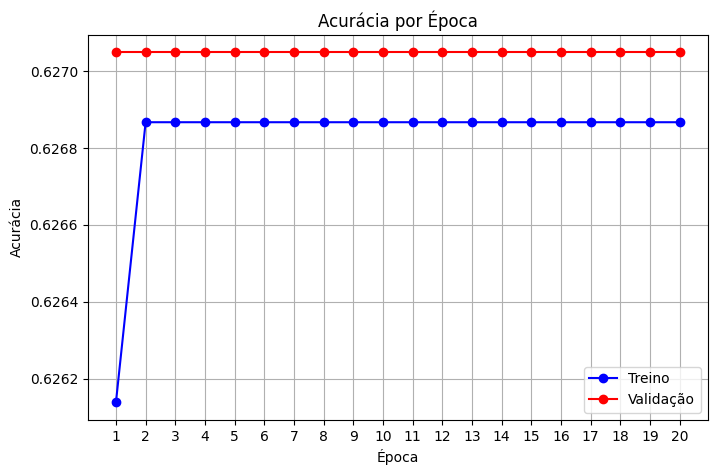

In [55]:
# Acurácia por época
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)

# Plotar
plt.figure(figsize=(8,5))
plt.plot(epochs, acc, 'bo-', label='Treino')
plt.plot(epochs, val_acc, 'ro-', label='Validação')
plt.title('Acurácia por Época')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.xticks(epochs)
plt.legend()
plt.grid(True)
plt.show()

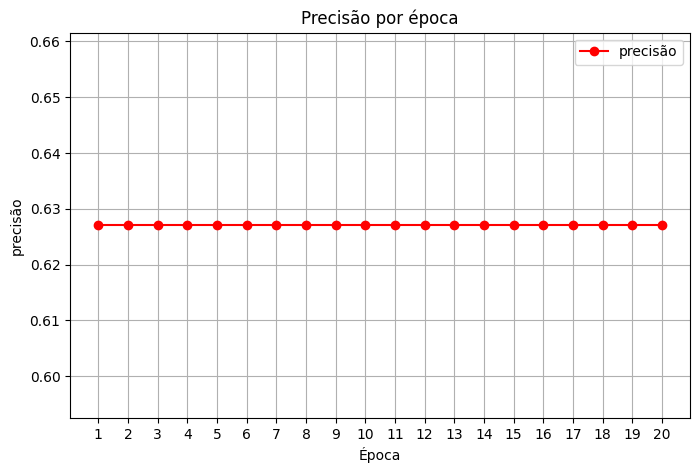

In [56]:
# Acurácia por época
acc = history.history['precision']
epochs = range(1, len(acc) + 1)

# Plotar
plt.figure(figsize=(8,5))
plt.plot(epochs, val_acc, 'ro-', label='precisão')
plt.title('Precisão por época')
plt.xlabel('Época')
plt.ylabel('precisão')
plt.xticks(epochs)
plt.legend()
plt.grid(True)
plt.show()

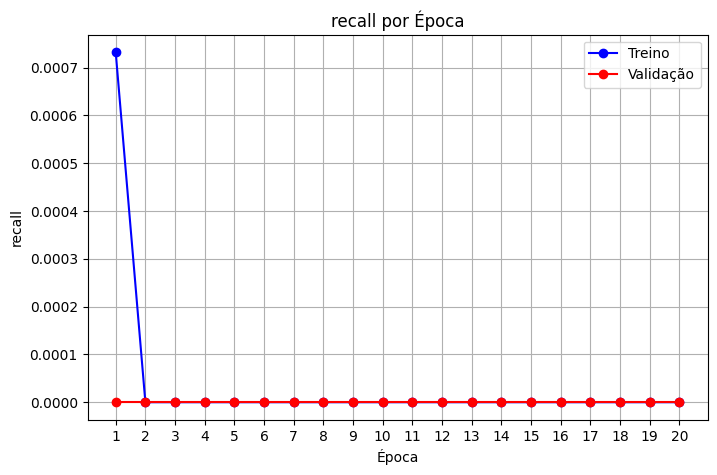

In [57]:
# Acurácia por época
acc = history.history['recall']
val_acc = history.history['val_recall']
epochs = range(1, len(acc) + 1)

# Plotar
plt.figure(figsize=(8,5))
plt.plot(epochs, acc, 'bo-', label='Treino')
plt.plot(epochs, val_acc, 'ro-', label='Validação')
plt.title('recall por Época')
plt.xlabel('Época')
plt.ylabel('recall')
plt.xticks(epochs)
plt.legend()
plt.grid(True)
plt.show()

115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step


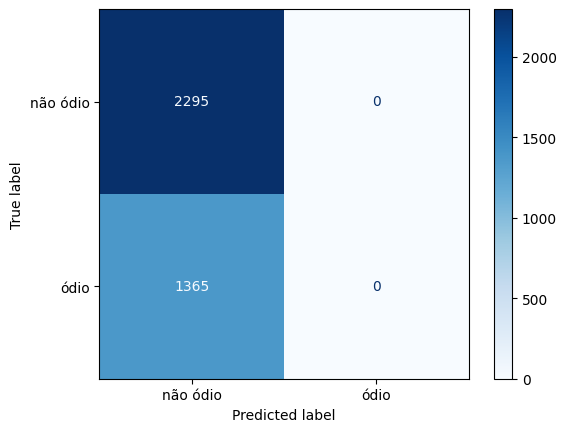

In [59]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Fazendo predições no conjunto de validação
y_pred_probs = model.predict(X_val_pad)

# Convertendo probabilidades para classes (0 ou 1)
y_pred_labels = (y_pred_probs > 0.5).astype(int).flatten()

# Plotando a matriz de confusão
cm = confusion_matrix(y_val, y_pred_labels, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["não ódio", "ódio"])
disp.plot(cmap="Blues")
plt.show()

# **Modelo bidirecional + camada de atenção**

In [67]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Bidirectional, Attention, GlobalAveragePooling1D
from tensorflow.keras.metrics import Precision, Recall, F1Score
from tensorflow.keras.callbacks import EarlyStopping

# Parâmetros
embedding_dim = 128
max_len = X_train_pad.shape[1]
vocab_size = min(10000, len(tokenizer.word_index) + 1)

# Definindo a RNN com Camada de Atenção
inputs = Input(shape=(max_len,))
x = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len)(inputs)
# A camada LSTM deve retornar sequências completas para que a camada de atenção possa processá-las
lstm_out = Bidirectional(LSTM(64, return_sequences=True))(x)

# Camada de Atenção
attention_out = Attention()([lstm_out, lstm_out])

# Combinar a saída da atenção para criar um único vetor de contexto para toda a frase
context_vector = GlobalAveragePooling1D()(attention_out)

# Adicionar a camada de Dropout e a camada de saída
x = Dropout(0.5)(context_vector)
outputs = Dense(1, activation='sigmoid')(x)

# Criar o modelo
model_attention = Model(inputs=inputs, outputs=outputs)

early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True) 


# Compilação
model_attention.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy', 
        Precision(name='precision'),
        Recall(name='recall'),
        F1Score(name='f1_score') 
    ]
)

# Treinamento
history_attention = model_attention.fit(
    X_train_pad,
    y_train,
    epochs=20,
    batch_size=50,
    validation_data=(X_val_pad, y_val),
    callbacks=[early_stopping]
) 

Epoch 1/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 39s 151ms/step - accuracy: 0.6798 - f1_score: 0.5435 - loss: 0.6022 - precision: 0.7141 - recall: 0.2365 - val_accuracy: 0.8093 - val_f1_score: 0.5433 - val_loss: 0.4599 - val_precision: 0.8210 - val_recall: 0.6249
Epoch 2/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 36s 164ms/step - accuracy: 0.8514 - f1_score: 0.5435 - loss: 0.3578 - precision: 0.8115 - recall: 0.7837 - val_accuracy: 0.8421 - val_f1_score: 0.5433 - val_loss: 0.3736 - val_precision: 0.8020 - val_recall: 0.7656
Epoch 3/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 39s 157ms/step - accuracy: 0.9015 - f1_score: 0.5435 - loss: 0.2604 - precision: 0.8779 - recall: 0.8550 - val_accuracy: 0.8358 - val_f1_score: 0.5433 - val_loss: 0.3737 - val_precision: 0.7664 - val_recall: 0.8051
Epoch 4/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 32s 145ms/step - accuracy: 0.9299 - f1_score: 0.5435 - loss: 0.1947 - precision: 0.9121 - recall: 0.8987 - val_accuracy: 0.8369 - val_f1_score: 0.5433 - val_loss: 0.4479 - val_precision: 0.8024 -

115/115 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step


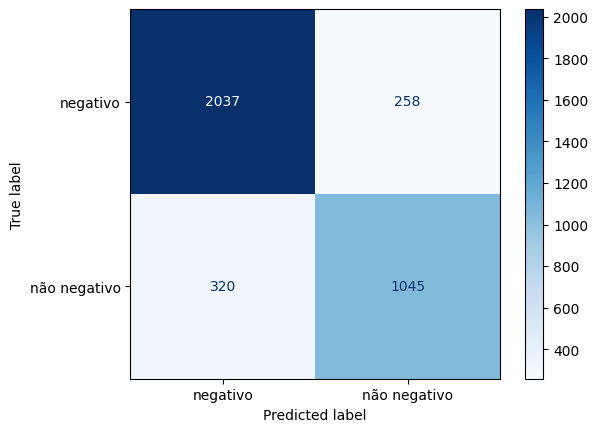

In [68]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Fazendo predições no conjunto de validação
y_pred_probs = model_attention.predict(X_val_pad)

# Convertendo probabilidades para classes (0 ou 1)
y_pred_labels = (y_pred_probs > 0.5).astype(int).flatten()

# Plotando a matriz de confusão
cm = confusion_matrix(y_val, y_pred_labels, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["negativo", "não negativo"])
disp.plot(cmap="Blues")
plt.show()

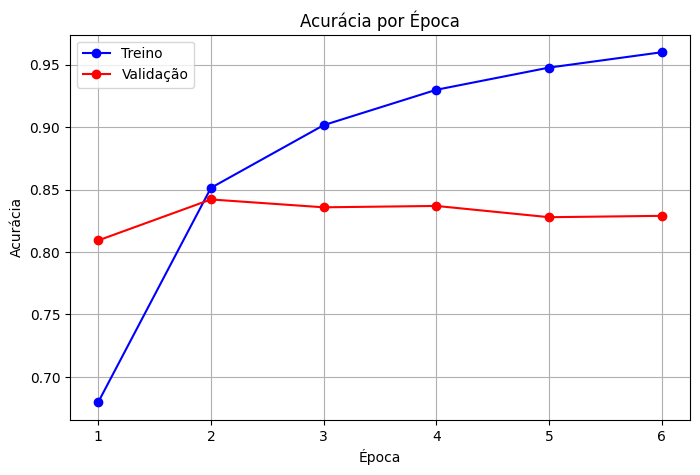

In [69]:
# Acurácia por época
acc = history_attention.history['accuracy']
val_acc = history_attention.history['val_accuracy']
epochs = range(1, len(acc) + 1)

# Plotar
plt.figure(figsize=(8,5))
plt.plot(epochs, acc, 'bo-', label='Treino')
plt.plot(epochs, val_acc, 'ro-', label='Validação')
plt.title('Acurácia por Época')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.xticks(epochs)
plt.legend()
plt.grid(True)
plt.show()

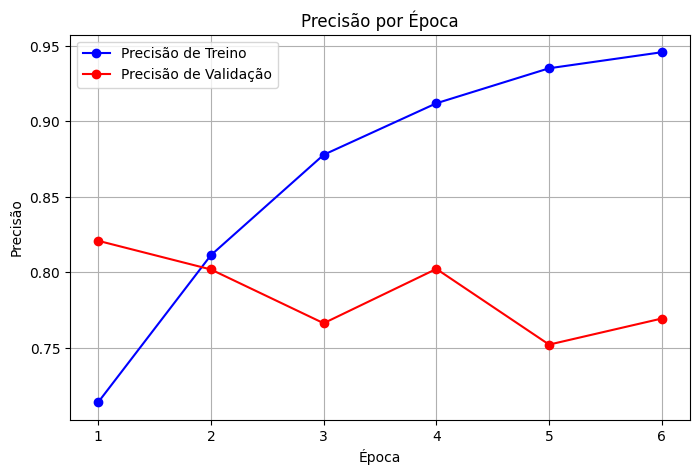

In [73]:

# Extrair os dados de precisão do histórico
precision_treino = history_attention.history['precision']
precision_validacao = history_attention.history['val_precision']
epochs = range(1, len(precision_treino) + 1)

# Plotar a precisão
plt.figure(figsize=(8, 5))
plt.plot(epochs, precision_treino, 'bo-', label='Precisão de Treino')
plt.plot(epochs, precision_validacao, 'ro-', label='Precisão de Validação')
plt.title('Precisão por Época')
plt.xlabel('Época')
plt.ylabel('Precisão')
plt.xticks(epochs)
plt.legend()
plt.grid(True)
plt.show()